<a href="https://colab.research.google.com/github/8Raouf24/PFE/blob/master/RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Voici le notebook contenant le code du Filtrage collaboratif . On essaye de deviner la note donné par des utilisateurs aux articles d'Amazon qu'ils n'ont pas notés . Voici les étapes qui seront suivis :


1.   Charger les données et les transformer en DataFrame
2.   Pré-traitement des données pour faciliter le training
3.   Création du réseaux de neuronnes 
4.   Training du réseaux de neuronnes
5.   Recommandation








In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,callbacks
from pathlib import Path
import gzip
import matplotlib.pyplot as plt
import json

Tout d'abord , nous téléchargons la base de données sur laquelle nous effectuerons nos travaux. Dans le cas échant nous utiliserons " Musical_Instruments_5" qui contient des articles d'Amazon appartenant a la catégorie " Instrument musical " ayant été noté par au moins 5  utilisateurs.

In [2]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Musical_Instruments_5.json.gz

--2020-08-12 16:46:45--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Musical_Instruments_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39356138 (38M) [application/octet-stream]
Saving to: ‘Musical_Instruments_5.json.gz’

Musical_Instruments 100%[===================>]  37.53M  13.4MB/s    in 2.8s    

2020-08-12 16:46:48 (13.4 MB/s) - ‘Musical_Instruments_5.json.gz’ saved [39356138/39356138]



Nous chargeons nos données depuis notre fichier json sous le format d'une liste afin de pouvoir faire la conversion vers un DataFrame.

In [3]:
#Chargement des données sous le format liste
data = []
with gzip.open('Musical_Instruments_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# Nombre total de produit
print(len(data))

# Un exemple de produit
print(data[0])

231392
{'overall': 5.0, 'verified': True, 'reviewTime': '10 30, 2016', 'reviewerID': 'A3FO5AKVTFRCRJ', 'asin': '0739079891', 'reviewerName': 'francisco', 'reviewText': "It's good for beginners", 'summary': 'Five Stars', 'unixReviewTime': 1477785600}


Une fois notre Dataframe crée , nous le filtrerons afin de récolter les données pertinantes pour notre systéme de recommandation , c'est à dire les utilisateurs , les articles , et les ratings.

In [4]:
#Transformation de nos données depuis le format liste vers le format dataframe
df = pd.DataFrame.from_dict(data)

data_dict = {'userID':df['reviewerID'],'itemID':df['asin'],'rating':df['overall']}
df_rs = pd.DataFrame.from_dict(data_dict)
df = df_rs

#Un exemple de ligne de notre dataframe
print(df_rs.iloc[0])

userID    A3FO5AKVTFRCRJ
itemID        0739079891
rating                 5
Name: 0, dtype: object


Ici , les prétraitements consisteront a transformer nos utilisateurs et nos articles en des indices d'entiers naturels.

In [8]:
#Tout d'abord , nous recuillons les users de facon unique dans une liste
user_ids = df_rs["userID"].unique().tolist()
#Nous représentons chaque utilisateur de notre liste en un nombre entier et vice versa
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

#Meme travail pour les articles
item_ids = df_rs["itemID"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}

#Nous remplacons les colonnes de notre DF contenant les ID des utilisateurs et des articles sous format caractères par le format encodé en  nombre entier
df_rs["user"] = df_rs["userID"].map(user2user_encoded)
df_rs["item"] = df_rs["itemID"].map(item2item_encoded)

#Nous récupérons la taille des vecteurs des utilisateurs et articles
num_users = len(user2user_encoded)
num_items = len(item_encoded2item)

#Nous covnertissions les notes du format int au format float
df_rs["rating"] = df_rs["rating"].values.astype(np.float32)

#Le min et le max seront utilisés pour la normalisation un peu plus tard
min_rating = min(df_rs["rating"])
max_rating = max(df_rs["rating"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)


Number of users: 27530, Number of Items: 10620, Min rating: 1.0, Max rating: 5.0


Nous préparons notre training et validation set

In [11]:
#La fonction ci-dessous nous retourne une fraction de notre datafarme sous un ordre aléatoire
df_rs = df_rs.sample(frac=1, random_state=42)

#Nous définissons notre input ( liste de tuple user item)
x = df_rs[["user", "item"]].values


# On normalise notre target (le rating) pour faciliter le training
y = df_rs["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# 70% du dataset sera utilisé pour le training et 30% pour la validation
train_indices = int(0.7 * df_rs.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)




Nous créeons notre modèle en vectorisant le vecteur d'un user et le vecteur d'un article en un seul vecteur de dimension 50.
Notre modèle calculera alors un score de correspondance  entre le vecteur de l'utilisateur et celui de l'article via un produit scalaire en ajoutant un biais par item et un biais par article . Le résultat sera entre un intervall de 0 et 1 via un sigmoid ( vu que nos ratings sont normalisés sur cette intervall)

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        #Voici les inputs de notre modèle
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        """Nous utilisons l'API layers de keras pour invoquer la fonction Embedding 
        permettant de transformer des indices positifs en un vecteur dense de taille fixe (ce sera la premiere couche de notre réseau qui nous servira d'encoder )"""

        #On vectorise les user , Shape (None,27530,50)
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        #Shape (None,10620,1)
        self.user_bias = layers.Embedding(num_users, 1)

        #On vectorise les items , Shape (None,10620,50)
        self.item_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        #Shape (None,10620,1)
        self.item_bias = layers.Embedding(num_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])

        #Nous effectuons le produit scalaire entre les vecteurs encodés des articles et des utilisateurs pour fusionner les deux layers
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)

        # nous ajoutons tout les composantes (y compris le biais)
        x = dot_user_item + user_bias + item_bias

        # La fonction d'activation sigmoid force le résultat a étre une valeur entre 0 et 1 (pour respecter notre normalisation)
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
#Ici nous utilisons l'optimiseur Adam (va variant on Stochastic Gradient Descent) qui altère l'embedding lors du training pour minimiser la perte qui est representé par Binary crossentropy
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.01),
     metrics=[tf.keras.metrics.RootMeanSquaredError(),"mae"])
es = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', mode='min', verbose=1, patience=10)


We train our model on the data split 

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=200,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es],
)


Epoch 1/200
2893/2893 [==============================] - 49s 17ms/step - loss: 0.6814 - root_mean_squared_error: 0.4352 - mae: 0.4097 - val_loss: 0.6627 - val_root_mean_squared_error: 0.4244 - val_mae: 0.3997
Epoch 2/200
2893/2893 [==============================] - 47s 16ms/step - loss: 0.5747 - root_mean_squared_error: 0.3702 - mae: 0.3468 - val_loss: 0.5378 - val_root_mean_squared_error: 0.3458 - val_mae: 0.3220
Epoch 3/200
2893/2893 [==============================] - 47s 16ms/step - loss: 0.4254 - root_mean_squared_error: 0.2683 - mae: 0.2266 - val_loss: 0.4354 - val_root_mean_squared_error: 0.2755 - val_mae: 0.2370
Epoch 4/200
2893/2893 [==============================] - 46s 16ms/step - loss: 0.3948 - root_mean_squared_error: 0.2472 - mae: 0.1883 - val_loss: 0.4253 - val_root_mean_squared_error: 0.2682 - val_mae: 0.2280
Epoch 5/200
2893/2893 [==============================] - 46s 16ms/step - loss: 0.3908 - root_mean_squared_error: 0.2450 - mae: 0.1846 - val_loss: 0.4246 - val_root_

PLot training , and validation rmse

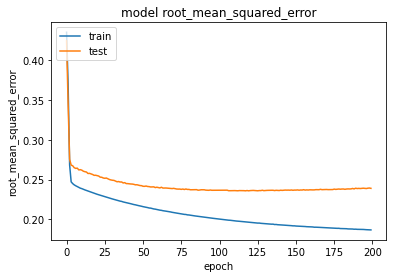

In [ ]:
plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("model root_mean_squared_error")
plt.ylabel("root_mean_squared_error")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

source = "Building a Recommendation System Using Neural Network Embeddings" Will Kohersen